In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#df = pd.read_csv('../experiments/sw-data/amd.csv')
df = pd.read_csv('../experiments/sw-data/sigmax.csv')
#df = pd.read_csv('../experiments/sw-data/gpu_sigmax.csv')
#df = pd.read_csv('../experiments/sw-data/debug.csv')
#df = pd.read_csv('../experiments/sw-data/power_battery.csv')

df['time'] = df['time_alloc'] + df['time_parse'] + df['time_walk']
del df['bytes_out']
df['throughput'] = df['bytes_in'] / df['time']
# df.set_index(['framework', 'api', 'allocated', 'max_values', 'num_jsons'], inplace=True)
df.sort_values(['max_values', 'throughput'], inplace=True)

In [3]:
dg = df.groupby(['framework', 'max_values', 'bytes_in']).agg({'throughput':'max'})
dg.sort_values(by=['framework', 'max_values'], inplace=True)
dg['Throughput (GB/s)'] = dg.throughput * 1e-9
del dg['throughput']

In [4]:
dh = dg.unstack('framework')
dh.index.rename(inplace=True, names=['Max. values', 'Bytes in'])
dh = dh.droplevel(0, axis=1)
dh = dh.reindex(dh.mean().sort_values(ascending=False).index, axis=1)
display(dh)

,framework,cuDF,Custom,Boost Spirit.X3,RapidJSON,simdjson
Max. values,Bytes in,,,,,
1,536870925,0.158163,0.401608,0.489576,0.297358,0.304682
2,536870915,0.447739,0.363707,0.407840,0.265646,0.244169
4,536870933,0.463827,0.335924,0.351260,0.242563,0.247575
8,536870936,0.482342,0.337616,0.319109,0.223279,0.216306
16,536870928,0.388381,0.311110,0.274171,0.205378,0.195506
32,536870960,0.406421,0.313120,0.260000,0.196138,0.173384
64,536870929,0.459928,0.312886,0.259577,0.207204,0.175662
128,536871025,0.481610,0.317581,0.256450,0.195662,0.179070
256,536871777,0.480043,0.304578,0.246134,0.189892,0.188051


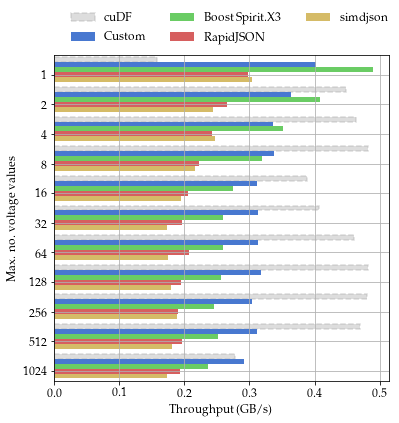

In [9]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 12
})

#dh.columns.rename(inplace=True, name='Framework')
#dh.index.rename(inplace=True, name='Max. values')

fig, ax = plt.subplots(figsize=(6, 6))
colors = ['#dc7ec0', '#4878d0', '#6acc64', '#d65f5f', '#d5bb67']

y_labels = [x[0] for x in dh.index.to_list()]
y_ticks = np.arange(0, len(y_labels))

impls = dh.columns.to_list()
bars = []
height = 1/(len(impls)+1)

for i, impl in enumerate(impls):
    x = dh[impl].to_numpy()
    y = np.arange(0, len(x))
    c = colors[i]
    if impl == "cuDF":
        c = '#AAAAAA'
        a = 0.4
        lw = 1.5
        ec = '#AAAAAA'
    else:
        a = 1
        lw = 0

    b = ax.barh(y=y+i*height, 
                width=x, 
                height=height, 
                color=c, 
                alpha=a, 
                linewidth=lw, 
                edgecolor=ec,
                ls='--')
    bars.append(b)

ax.set_ylim(-height, len(y_labels)-height)
ax.set_yticks(y_ticks + 0.5)
ax.set_yticklabels(y_labels)
ax.set_ylabel("Max. no. voltage values")
ax.invert_yaxis()

ax.set_xlabel("Throughput (GB/s)")

ax.grid(which='both')

ax.legend(bars, impls, ncol=3, bbox_to_anchor=(0.018, 1.0), frameon=False)

fig.savefig('software.pdf')